<a href="https://colab.research.google.com/github/beyzoskaya/ClassificationCIFAR10/blob/main/vgg_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

In [61]:

# data_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

In [99]:
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std  = [ 0.229, 0.224, 0.225 ]),
    ])

In [100]:
cifar10_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=data_transform)

Files already downloaded and verified


In [101]:
total_size = len(cifar10_full)
total_size

50000

In [102]:
class_indices = [[] for _ in range(10)]
for i, (image,label) in enumerate(cifar10_full):
  class_indices[label].append(i)

In [103]:
from torch.utils.data import Subset

train_size_per_class = 600
val_size_per_class = 200
test_size_per_class = 200

train_indices = []
val_indices = []
test_indices = []

for indices in class_indices:
  train_indices.extend(indices[:train_size_per_class])
  val_indices.extend(indices[train_size_per_class:train_size_per_class + val_size_per_class])
  test_indices.extend(indices[train_size_per_class + val_size_per_class:train_size_per_class + val_size_per_class + test_size_per_class])

cifar10_train = Subset(cifar10_full, train_indices)
cifar10_val = Subset(cifar10_full, val_indices)
cifar10_test = Subset(cifar10_full, test_indices)

In [104]:
len(cifar10_train), len(cifar10_val), len(cifar10_test)

(6000, 2000, 2000)

In [105]:
def get_class_numbers(dataset):
  return set(sample[1] for sample in dataset)

class_train = get_class_numbers(cifar10_train)
class_val = get_class_numbers(cifar10_val)
class_test = get_class_numbers(cifar10_test)

print("Classes in the train set: ", class_train)
print("Number of classes in the train set: ", len(class_train))

print("\nclasses in the validation set:", class_val)
print("Number of unique classes in the validation set:", len(class_val))

print("\nClasses in the test set:", class_test)
print("Number of unique classes in the test set:", len(class_test))

Classes in the train set:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Number of classes in the train set:  10

classes in the validation set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Number of unique classes in the validation set: 10

Classes in the test set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Number of unique classes in the test set: 10


In [106]:
from collections import Counter

def count_images_per_class(dataset):
  return Counter(sample[1] for sample in dataset)

images_per_class_train = count_images_per_class(cifar10_train)
images_per_class_val = count_images_per_class(cifar10_val)
images_per_class_test = count_images_per_class(cifar10_test)

print("Number of images per class in the train set:")
for class_label, count in images_per_class_train.items():
    print(f"Class {class_label}: {count} images")

print("\nNumber of images per class in the validation set:")
for class_label, count in images_per_class_val.items():
    print(f"Class {class_label}: {count} images")

print("\nNumber of images per class in the test set:")
for class_label, count in images_per_class_test.items():
    print(f"Class {class_label}: {count} images")

Number of images per class in the train set:
Class 0: 600 images
Class 1: 600 images
Class 2: 600 images
Class 3: 600 images
Class 4: 600 images
Class 5: 600 images
Class 6: 600 images
Class 7: 600 images
Class 8: 600 images
Class 9: 600 images

Number of images per class in the validation set:
Class 0: 200 images
Class 1: 200 images
Class 2: 200 images
Class 3: 200 images
Class 4: 200 images
Class 5: 200 images
Class 6: 200 images
Class 7: 200 images
Class 8: 200 images
Class 9: 200 images

Number of images per class in the test set:
Class 0: 200 images
Class 1: 200 images
Class 2: 200 images
Class 3: 200 images
Class 4: 200 images
Class 5: 200 images
Class 6: 200 images
Class 7: 200 images
Class 8: 200 images
Class 9: 200 images


In [107]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataset,num_images=5):
  fig,axes = plt.subplots(1,num_images, figsize=(15,3))

  random_indices = np.random.choice(len(dataset), num_images, replace=False)

  for i,idx in enumerate(random_indices):
    image, label = dataset[idx]
    image = np.transpose(image.numpy(), (1,2,0))
    axes[i].imshow((image + 1) / 2)
    axes[i].set_title(f"Class: {label}")
    axes[i].axis('off')
  plt.show()

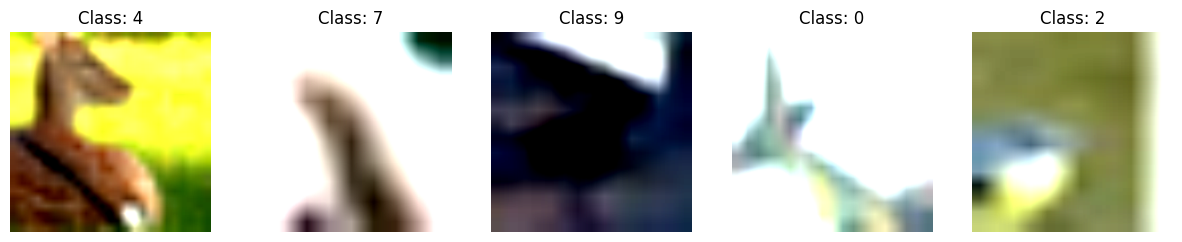

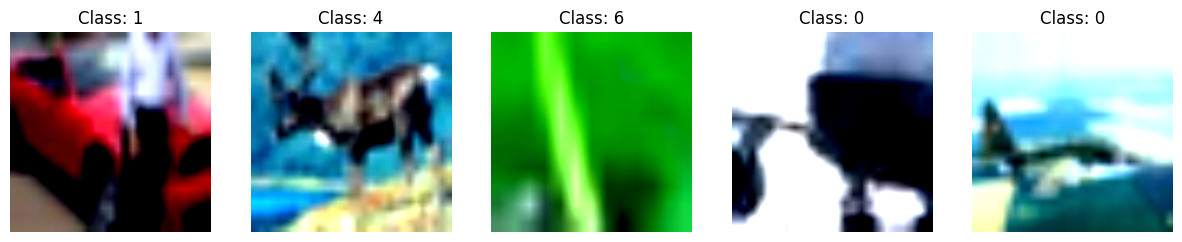

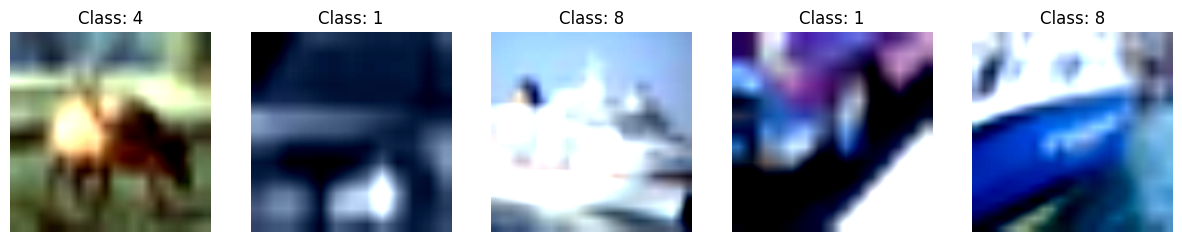

In [108]:
show_images(cifar10_train)
show_images(cifar10_val)
show_images(cifar10_test)

In [109]:
class_names = cifar10_full.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [110]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(cifar10_train,
                              batch_size=BATCH_SIZE,
                              num_workers=2,
                              shuffle=True)
val_dataloader = DataLoader(cifar10_val,
                            batch_size=BATCH_SIZE,
                            num_workers=2,
                            shuffle=False)

test_dataloader = DataLoader(cifar10_test,
                            batch_size=BATCH_SIZE,
                            num_workers=2,
                            shuffle=False)

In [118]:
import torch
from torch import nn

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        # Define the convolutional layers
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [119]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
vgg16_model = VGG16()
vgg16_model

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [92]:
img_batch, label_batch = next(iter(train_dataloader))


img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")


vgg16_model.eval()
with torch.inference_mode():
    pred = vgg16_model(img_single)

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 32, 32])

Output logits:
tensor([[ 0.0063, -0.0002, -0.0064, -0.0023,  0.0119,  0.0100, -0.0064, -0.0159,
          0.0055, -0.0104]])

Output prediction probabilities:
tensor([[0.1007, 0.1001, 0.0994, 0.0998, 0.1013, 0.1011, 0.0994, 0.0985, 0.1006,
         0.0990]])

Output prediction label:
tensor([4])

Actual label:
2


In [125]:
from typing import Tuple
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device) -> Tuple[float, float]:
  model.train()
  train_loss, train_acc = 0,0
  for batch,(X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [121]:
def validate(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device) -> Tuple[float, float]:
  model.eval()
  val_loss, val_acc = 0,0
  with torch.no_grad():
    for batch, (X_val, y_val) in enumerate(dataloader):
      X_val, y_val = X_val.to(device), y_val.to(device)
      y_val_pred = model(X_val)
      loss_val = loss_fn(y_val_pred, y_val)
      val_loss += loss_val.item()

      y_val_pred_class = torch.argmax(torch.softmax(y_val_pred, dim=1), dim=1)
      val_acc += (y_val_pred_class == y_val).sum().item() / len(y_val_pred)

  val_loss = val_loss / len(dataloader)
  val_acc = val_acc / len(dataloader)
  return val_loss, val_acc

In [122]:
def test(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               device: torch.device) -> float:

    model.eval()

    test_accuracy = 0.0

    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_test_pred = model(X_test)

            _, predicted = torch.max(y_test_pred, 1)
            test_accuracy += (predicted == y_test).sum().item()

    test_accuracy /= len(dataloader.dataset)
    return test_accuracy


In [123]:
num_epochs = 100
vgg16_model = VGG16().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vgg16_model.parameters(), lr=0.001)

In [126]:
from timeit import default_timer as timer
start_time = timer()

for epoch in range(num_epochs):

  train_loss, train_acc = train(model=vgg16_model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
  print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}")
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Epoch 1/100, Training Loss: 2.302964687347412, Training Accuracy: 0.09391622340425532
Epoch 2/100, Training Loss: 2.3030264377593994, Training Accuracy: 0.09175531914893617
Epoch 3/100, Training Loss: 2.3029541969299316, Training Accuracy: 0.09790558510638298
Epoch 4/100, Training Loss: 2.3030025959014893, Training Accuracy: 0.09092420212765957
Epoch 5/100, Training Loss: 2.3029205799102783, Training Accuracy: 0.09142287234042554
Epoch 6/100, Training Loss: 2.302855968475342, Training Accuracy: 0.09225398936170212
Epoch 7/100, Training Loss: 2.3027520179748535, Training Accuracy: 0.09424867021276596
Epoch 8/100, Training Loss: 2.3028404712677, Training Accuracy: 0.09424867021276596
Epoch 9/100, Training Loss: 2.3028993606567383, Training Accuracy: 0.09674202127659574
Epoch 10/100, Training Loss: 2.30287766456604, Training Accuracy: 0.0954122340425532
Epoch 11/100, Training Loss: 2.302842140197754, Training Accuracy: 0.09591090425531915
Epoch 12/100, Training Loss: 2.302797794342041, Tr

KeyboardInterrupt: ignored